Modified Train Size: 165
Modified Test Size: 44


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 170MB/s]


Modified Split Epoch 1 Training Loss = 0.6175876458485922
Modified Split Epoch 2 Training Loss = 0.4242354730765025
Modified Split Epoch 3 Training Loss = 0.32659462094306946
Modified Test Accuracy = 0.8863636363636364
Modified Misclassified Indices: [2, 19, 20, 42, 43]


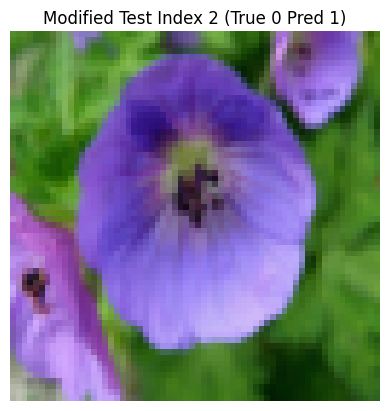

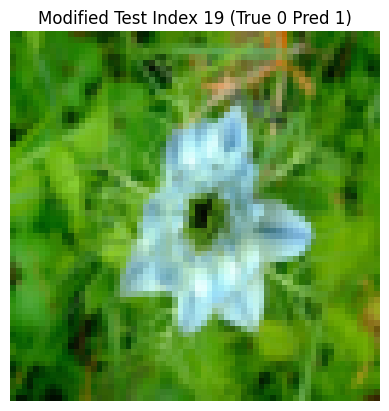

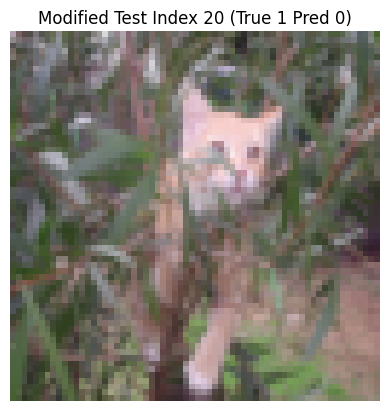

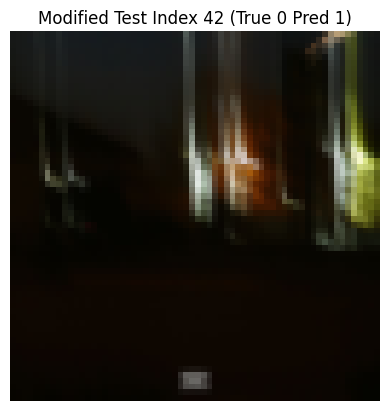

In [4]:
# Section 5: Binary Image Classification (Modified Dataset)

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import h5py
import matplotlib.pyplot as plt

# select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# dataset class
class H5ImageDataset(Dataset):
    def __init__(self, path):
        with h5py.File(path, "r") as hf:
            self.X = np.array(hf["train_set_x"])
            self.y = np.array(hf["train_set_y"])

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], int(self.y[idx])

# load original training data
train_path = "train_catvnoncat.h5"
dataset_full = H5ImageDataset(train_path)

orig_X = dataset_full.X
orig_y = dataset_full.y

# compute modified split point
last_digit = 5
new_train_count = 160 + last_digit  # = 165
new_train_count = min(new_train_count, len(orig_X) - 1)

# split the dataset
mod_train_X = orig_X[:new_train_count]
mod_train_y = orig_y[:new_train_count]

mod_test_X = orig_X[new_train_count:]
mod_test_y = orig_y[new_train_count:]

print("Modified Train Size:", len(mod_train_X))
print("Modified Test Size:", len(mod_test_X))

# create dataset wrapper for arrays
class ArrayDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = self.X[idx]
        label = int(self.y[idx])
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(label, dtype=torch.float32)

# transformation pipeline
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

train_mod = ArrayDataset(mod_train_X, mod_train_y, transform)
test_mod  = ArrayDataset(mod_test_X, mod_test_y, transform)

train_mod_loader = DataLoader(train_mod, batch_size=8, shuffle=True)
test_mod_loader  = DataLoader(test_mod, batch_size=8, shuffle=False)

# build model
model2 = models.resnet18(pretrained=True)
model2.fc = nn.Linear(model2.fc.in_features, 1)
model2 = model2.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model2.parameters(), lr=1e-5)

# train the model
epochs = 3
model2.train()
for e in range(epochs):
    losses = []
    for imgs, labels in train_mod_loader:
        imgs = imgs.to(device)
        labels = labels.to(device).unsqueeze(1)

        optimizer.zero_grad()
        out = model2(imgs)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    print(f"Modified Split Epoch {e+1} Training Loss =", np.mean(losses))

# evaluate modified model
model2.eval()
pred_mod = []
true_mod = []

with torch.no_grad():
    for imgs, labels in test_mod_loader:
        imgs = imgs.to(device)
        out = model2(imgs)
        p = torch.sigmoid(out).cpu().numpy().flatten()

        pred_mod.extend((p > 0.5).astype(int))
        true_mod.extend(labels.numpy().astype(int))

pred_mod = np.array(pred_mod)
true_mod = np.array(true_mod)

if len(true_mod) > 0:
    acc_mod = np.mean(pred_mod == true_mod)
    print("Modified Test Accuracy =", acc_mod)

    mis_mod = np.where(pred_mod != true_mod)[0]
    print("Modified Misclassified Indices:", mis_mod.tolist())

    # display first 4 misclassified
    for i in range(min(4, len(mis_mod))):
        idx = mis_mod[i]
        img = mod_test_X[idx]
        plt.imshow(img.astype(np.uint8))
        plt.title(f"Modified Test Index {idx} (True {true_mod[idx]} Pred {pred_mod[idx]})")
        plt.axis("off")
        plt.show()
else:
    print("Modified Test Set Is Empty.")